In [14]:
import xgboost as xgb
import pandas as pd
import src.train_utils as T
import xarray as xr
import itertools
import numpy as np
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error

# 1) show every column
pd.set_option('display.max_columns', None)

# 2) disable automatic expansion/wrapping
pd.set_option('display.expand_frame_repr', False)

# 3) bump the console width way up (or to None for ‘no limit’)
pd.set_option('display.width', None)

In [2]:
ds = xr.open_dataset('../datasets/exp_5_ds.nc')
mask = ds.time.dt.year < 2022
ds_excl_2022 = ds.sel(time=mask)

pm25_da = ds_excl_2022['pm25_t']
frp_da = ds_excl_2022['frp_max_7x7']

ds_excl_2022['spatdif_3x3'] = pm25_da - pm25_da.rolling(i=3, j=3, center=True).mean()
ds_excl_2022['spatdif_5x5'] = pm25_da - pm25_da.rolling(i=5, j=5, center=True).mean()
ds_excl_2022['spatdif_7x7'] = pm25_da - pm25_da.rolling(i=7, j=7, center=True).mean()

# 3-day rolling sum of FRP at time t
frp_sum3 = frp_da.rolling(time=3, center=False, min_periods=1).sum().rename("frp_sum3")
ds_excl_2022["frp_sum3"] = frp_sum3

train_df = ds_excl_2022.to_dataframe().reset_index()

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [5]:
train_df

,time,i,j,pm25_t,u_wind_t,v_wind_t,dew_temp_t,temp_t,surf_pressure_t,precip_t,frp_t,elevation_t,delta_pm25_t+1,delta_pm25_t,r_humidity_t,delta_pm25_t-1,delta_pm25_t-2,delta_pm25_t-3,delta_pm25_avg_3x3,delta_pm25_avg_5x5,delta_pm25_avg_7x7,delta_pm25_avg_9x9,pm25_avg_3x3,pm25_avg_5x5,pm25_avg_7x7,pm25_avg_9x9,frp_max_3x3,frp_max_5x5,frp_max_7x7,frp_max_9x9,frp_sum_3x3,frp_sum_5x5,frp_sum_7x7,frp_sum_9x9,frp_buffer_sum_3x3,frp_buffer_sum_5x5,frp_buffer_sum_7x7,frp_buffer_sum_9x9,month_01,month_02,month_03,month_04,month_05,month_06,month_07,month_08,month_09,month_10,month_11,month_12,spatdif_3x3,spatdif_5x5,spatdif_7x7,frp_sum3
0,2018-07-08,0,0,9.513633,1.040234,0.047216,291.942383,293.100189,85344.046875,1.115932e-02,0.0,1360.0,-0.491020,0.556278,98.281067,0.038002,0.601407,0.302968,0.789314,0.734057,0.640796,0.702518,9.580145,9.402309,9.308264,9.289756,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,1,0,0,0,0,0,NaN,NaN,NaN,0.000000
1,2018-07-08,0,1,8.694135,0.926424,0.103043,292.972748,294.421875,87667.421875,1.054819e-02,0.0,1189.0,0.339427,0.060918,97.862534,1.064866,-1.001619,0.522349,0.631020,0.626528,0.657130,0.674091,9.348599,9.319261,9.280797,9.243377,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,1,0,0,0,0,0,NaN,NaN,NaN,0.000000
2,2018-07-08,0,2,8.702046,0.784416,0.177018,293.667633,295.682129,89480.257812,9.948850e-03,0.0,975.0,0.625493,0.058055,97.051796,0.587489,-1.125940,0.973524,0.349193,0.602640,0.585718,0.532589,9.044597,9.259371,9.189150,9.094057,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,1,0,0,0,0,0,NaN,NaN,NaN,0.000000
3,2018-07-08,0,3,8.956724,0.609245,0.260147,293.460449,295.622559,89063.468750,9.994119e-03,0.0,1005.0,0.176971,0.167542,96.837585,0.669046,-0.095932,-0.419762,0.292146,0.400938,0.429089,0.381801,8.920217,9.014485,9.028864,8.922835,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,1,0,0,0,0,0,NaN,NaN,NaN,0.000000
4,2018-07-08,0,4,8.738454,0.311515,0.377131,293.645172,295.106354,88635.007812,1.240605e-02,0.0,1059.0,0.251034,0.208978,97.850403,0.311488,-0.186723,0.275500,0.179783,0.147805,0.167027,0.236561,8.804992,8.726237,8.746341,8.729681,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,1,0,0,0,0,0,NaN,NaN,NaN,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2410315,2021-12-31,43,39,19.179289,-2.037924,-0.773922,285.754028,292.923798,93622.000000,8.523463e-07,0.0,870.0,3.251724,-0.818115,89.703644,-0.246047,1.876458,-3.444041,-0.360418,-0.118820,0.219062,0.310993,19.293715,19.283501,19.538256,19.698202,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,1,NaN,NaN,NaN,0.000000
2410316,2021-12-31,43,40,19.785183,-1.737936,-0.684505,286.360718,292.731842,95092.710938,8.523463e-07,0.0,673.0,3.448175,0.615328,90.802773,-0.844317,2.134015,-4.559459,0.255882,0.625071,0.679208,0.541765,19.531576,19.910971,20.108007,19.881226,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,1,NaN,NaN,NaN,10.183223
2410317,2021-12-31,43,41,19.760014,-1.432130,-0.599300,286.689514,292.943512,95813.546875,8.523463e-07,0.0,819.0,2.571398,0.732499,90.972664,-1.900846,3.102393,-5.963127,1.370712,1.260495,0.994243,0.738863,20.370958,20.550623,20.431406,20.127874,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,1,NaN,NaN,NaN,10.183223
2410318,2021-12-31,43,42,21.715679,-1.049460,-0.781592,287.109741,293.839081,97267.125000,8.523463e-07,0.0,332.0,-0.948131,2.498683,90.343513,-2.307787,3.217414,-4.070193,1.816282,1.642737,1.325162,1.049587,21.143930,20.913256,20.746700,20.461267,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,1,NaN,NaN,NaN,10.183223


In [3]:
feature_experiments = [
    ('persistence', []),
]

model=DummyRegressor(strategy='constant', constant=0)

results = T.run_experiments(
    df=train_df, 
    model=model, 
    feature_experiments=feature_experiments, 
    train_days=365*2,
    gap_days=7*3,
    val_days=7*7
)

print(results)

  0%|          | 0/1 [00:00<?, ?it/s]

Running experiment: persistence


  0%|          | 0/10 [00:00<?, ?it/s]

    experiment  n_features  mean_rmse  mean_mae  rmse_fold_1  rmse_fold_2  rmse_fold_3  rmse_fold_4  rmse_fold_5  rmse_fold_6  rmse_fold_7  rmse_fold_8  rmse_fold_9  rmse_fold_10
0  persistence           0   4.770767   3.12517     1.783652     6.286166     5.223866     9.354229    14.504134     2.214257     1.003456     1.061782     1.985275      4.290848


In [6]:
base = ['delta_pm25_t', 'delta_pm25_t-1', 'delta_pm25_t-2', 'delta_pm25_t-3', 'pm25_t', 'u_wind_t', 'v_wind_t',
       'dew_temp_t', 'temp_t', 'surf_pressure_t', 'precip_t',
       'frp_t', 'elevation_t', 'r_humidity_t']

base += ['delta_pm25_avg_3x3', 'delta_pm25_avg_5x5', 'delta_pm25_avg_7x7', 'delta_pm25_avg_9x9']

base += ['pm25_avg_3x3', 'pm25_avg_5x5', 'pm25_avg_7x7', 'pm25_avg_9x9']

base += ['frp_max_3x3', 'frp_max_5x5', 'frp_max_7x7', 'frp_max_9x9']

base += ['frp_buffer_sum_3x3', 'frp_buffer_sum_5x5', 'frp_buffer_sum_7x7', 'frp_buffer_sum_9x9']

base += ['month_01', 'month_02', 'month_03', 'month_04', 'month_05', 'month_06', 'month_07', 'month_08', 'month_09', 'month_10', 'month_11', 'month_12']

params = {
    'max_depth': 4,            
    'learning_rate': 0.1,     
    'n_estimators': 150,     
    'subsample': 0.8,          
    'colsample_bytree': 0.8,   
    'objective': 'reg:pseudohubererror'   
}

feature_experiments = [
    ('base', base),
    ('base + frp_sum3', base + ['frp_sum3']),
]

model=xgb.XGBRegressor(**params, random_state=191)

results = T.run_experiments(
    df=train_df, 
    model=model, 
    feature_experiments=feature_experiments, 
    train_days=365*2,
    gap_days=21,
    val_days=49
)

print(results.sort_values('mean_rmse'))

  0%|          | 0/2 [00:00<?, ?it/s]

Running experiment: base


  0%|          | 0/10 [00:00<?, ?it/s]

Running experiment: base + frp_sum3


  0%|          | 0/10 [00:00<?, ?it/s]

        experiment  n_features  mean_rmse  mean_mae  rmse_fold_1  rmse_fold_2  rmse_fold_3  rmse_fold_4  rmse_fold_5  rmse_fold_6  rmse_fold_7  rmse_fold_8  rmse_fold_9  rmse_fold_10
0             base          42   4.221747  2.861813     1.637629     4.846499     4.975658     8.401618    12.723725     1.987511     0.907936     0.986088     1.807607      3.943198
1  base + frp_sum3          43   4.237462  2.873485     1.637896     4.842657     5.013473     8.411811    12.822195     1.987177     0.910941     0.984879     1.808133      3.955455


In [7]:
base = ['delta_pm25_t', 'delta_pm25_t-1', 'delta_pm25_t-2', 'delta_pm25_t-3', 'pm25_t', 'u_wind_t', 'v_wind_t',
       'dew_temp_t', 'temp_t', 'surf_pressure_t', 'precip_t',
       'frp_t', 'elevation_t', 'r_humidity_t']

base += ['delta_pm25_avg_3x3', 'delta_pm25_avg_5x5', 'delta_pm25_avg_7x7', 'delta_pm25_avg_9x9']

base += ['pm25_avg_3x3', 'pm25_avg_5x5', 'pm25_avg_7x7', 'pm25_avg_9x9']

base += ['frp_max_3x3', 'frp_max_5x5', 'frp_max_7x7', 'frp_max_9x9']

base += ['frp_buffer_sum_3x3', 'frp_buffer_sum_5x5', 'frp_buffer_sum_7x7', 'frp_buffer_sum_9x9']

base += ['month_01', 'month_02', 'month_03', 'month_04', 'month_05', 'month_06', 'month_07', 'month_08', 'month_09', 'month_10', 'month_11', 'month_12']

params = {
    'max_depth': 4,            
    'learning_rate': 0.1,     
    'n_estimators': 150,     
    'subsample': 0.8,          
    'colsample_bytree': 0.8,   
    'objective': 'reg:pseudohubererror'   
}

feature_experiments = [
    ('base', base),
    ('base + spatdif3', base + ['spatdif_3x3']),
    ('base + spatdif3 + spatdif5', base + ['spatdif_3x3', 'spatdif_5x5']),
    ('base + spatdif3 + spatdif5 + spatdif7', base + ['spatdif_3x3', 'spatdif_5x5', 'spatdif_7x7'])
]

model=xgb.XGBRegressor(**params, random_state=191)

results = T.run_experiments(
    df=train_df, 
    model=model, 
    feature_experiments=feature_experiments, 
    train_days=365*2,
    gap_days=21,
    val_days=49
)

print(results.sort_values('mean_rmse'))

  0%|          | 0/4 [00:00<?, ?it/s]

Running experiment: base


  0%|          | 0/10 [00:00<?, ?it/s]

Running experiment: base + spatdif3


  0%|          | 0/10 [00:00<?, ?it/s]

Running experiment: base + spatdif3 + spatdif5


  0%|          | 0/10 [00:00<?, ?it/s]

Running experiment: base + spatdif3 + spatdif5 + spatdif7


  0%|          | 0/10 [00:00<?, ?it/s]

                              experiment  n_features  mean_rmse  mean_mae  rmse_fold_1  rmse_fold_2  rmse_fold_3  rmse_fold_4  rmse_fold_5  rmse_fold_6  rmse_fold_7  rmse_fold_8  rmse_fold_9  rmse_fold_10
0                                   base          42   4.221747  2.861813     1.637629     4.846499     4.975658     8.401618    12.723725     1.987511     0.907936     0.986088     1.807607      3.943198
1                        base + spatdif3          43   4.233728  2.864117     1.633115     4.859093     4.989517     8.394929    12.842695     1.984990     0.916046     0.990373     1.804001      3.922519
2             base + spatdif3 + spatdif5          44   4.239603  2.876581     1.641980     4.856762     4.995763     8.480453    12.806449     1.967183     0.912716     0.988706     1.794593      3.951423
3  base + spatdif3 + spatdif5 + spatdif7          45   4.247812  2.872966     1.631340     4.865369     4.979424     8.376040    12.992264     1.980075     0.912628     0.986926   

In [ ]:
base = ['delta_pm25_t', 'delta_pm25_t-1', 'delta_pm25_t-2', 'delta_pm25_t-3', 'pm25_t', 'u_wind_t', 'v_wind_t',
       'dew_temp_t', 'temp_t', 'surf_pressure_t', 'precip_t',
       'frp_t', 'elevation_t', 'r_humidity_t', 'month']

base += ['delta_pm25_avg_3x3', 'delta_pm25_avg_5x5', 'delta_pm25_avg_7x7', 'delta_pm25_avg_9x9']

base += ['frp_max_3x3', 'frp_max_5x5', 'frp_max_7x7', 'frp_max_9x9']

base += ['spatdif_3x3', 'frp_sum3']

params = {
    'max_depth': 4,            
    'learning_rate': 0.1,     
    'n_estimators': 150,     
    'subsample': 0.8,          
    'colsample_bytree': 0.8,   
    'objective': 'reg:pseudohubererror'   
}


feature_experiments = [
    ('base', base)
]

model=xgb.XGBRegressor(**params, random_state=191)

results = T.run_experiments(
    df=train_df, 
    model=model, 
    feature_experiments=feature_experiments, 
    train_days=365*2,
    gap_days=21,
    val_days=49
)

print(results.sort_values('mean_rmse'))

  0%|          | 0/1 [00:00<?, ?it/s]

Running experiment: base


  0%|          | 0/10 [00:00<?, ?it/s]

  experiment  n_features  mean_rmse  rmse_fold_1  rmse_fold_2  rmse_fold_3  rmse_fold_4  rmse_fold_5  rmse_fold_6  rmse_fold_7  rmse_fold_8  rmse_fold_9  rmse_fold_10
0       base          25   4.225818     1.646122     4.881937     5.007555     8.400064    12.661599     1.990588     0.910573     0.982631     1.809242       3.96787


In [43]:
ds = xr.open_dataset('../datasets/exp_5_ds.nc')

pm25_da = ds['pm25_t']

ds['spatdif_3x3'] = pm25_da - pm25_da.rolling(i=3, j=3, center=True).mean()


train_mask = ds.time.dt.year < 2022
train_ds = ds.sel(time=train_mask)

test_mask = ds.time.dt.year == 2022
test_ds = ds.sel(time=test_mask)

# 4. Convert to DataFrame
train_df = train_ds.to_dataframe().reset_index()
test_df = test_ds.to_dataframe().reset_index()

In [54]:
from sklearn.metrics import root_mean_squared_error
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error

# Example: for delta PM2.5
bins = [-np.inf, -20, -5, 5, 20, np.inf]
labels = ['Large Decrease', 'Moderate Decrease', 'Stable', 'Moderate Increase', 'Large Increase']

test_df['delta_bin'] = pd.cut(test_df['delta_pm25_t+1'], bins=bins, labels=labels)

In [55]:
X_train, y_train = train_df.drop(['time', 'i', 'j', 'delta_pm25_t+1'], axis=1), train_df['delta_pm25_t+1']
X_test, y_test = test_df.drop(['time', 'i', 'j', 'delta_pm25_t+1'], axis=1), test_df['delta_pm25_t+1']

feature_experiments = [
    ('persistence', []),
]

model=DummyRegressor(strategy='constant', constant=0)

model.fit(X_train, y_train)

test_df['persistence_preds'] = model.predict(X_test)

print(mean_absolute_error(test_df['persistence_preds'], y_test))
print(root_mean_squared_error(test_df['persistence_preds'], y_test))

3.327080011367798
5.622398376464844


In [58]:
grouped = test_df.groupby('delta_bin')

results = []
for name, group in grouped:
    mae = mean_absolute_error(group['delta_pm25_t+1'], group['persistence_preds'])
    rmse = root_mean_squared_error(group['delta_pm25_t+1'], group['persistence_preds'])
    results.append({'Bin': name, 'MAE': mae, 'RMSE': rmse, 'Count': len(group)})

results_df = pd.DataFrame(results)

print(results_df)

                 Bin        MAE       RMSE   Count
0     Large Decrease  28.140314  29.426510    4513
1  Moderate Decrease   9.014769   9.664734   64550
2             Stable   1.558212   2.030435  534755
3  Moderate Increase   8.822825   9.465065   67756
4     Large Increase  26.412371  27.737143    4090


/var/folders/7_/y4vpj6ln7b90djzq_hscbgyr0000gn/T/ipykernel_70133/1882320693.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = test_df.groupby('delta_bin')


In [66]:
base = ['pm25_t', 'u_wind_t', 'v_wind_t',
       'dew_temp_t', 'temp_t', 'surf_pressure_t', 'precip_t',
       'frp_t', 'elevation_t']

X_train, y_train = train_df[base], train_df['delta_pm25_t+1']
X_test, y_test = test_df[base], test_df['delta_pm25_t+1']

params = {
    'max_depth': 4,            
    'learning_rate': 0.09,     
    'n_estimators': 350,     
    'subsample': 0.8,          
    'colsample_bytree': 0.8, 
    'objective': 'reg:pseudohubererror'   
}

basic_xgb=xgb.XGBRegressor(**params, random_state=191)

basic_xgb.fit(X_train, y_train)

test_df['xgboost_basic_preds'] = basic_xgb.predict(X_test)

print(mean_absolute_error(test_df['xgboost_basic_preds'], y_test))
print(root_mean_squared_error(test_df['xgboost_basic_preds'], y_test))

3.1600985527038574
5.239895820617676


In [60]:
grouped = test_df.groupby('delta_bin')

results = []
for name, group in grouped:
    mae = mean_absolute_error(group['delta_pm25_t+1'], group['xgboost_basic_preds'])
    rmse = root_mean_squared_error(group['delta_pm25_t+1'], group['xgboost_basic_preds'])
    results.append({'Bin': name, 'MAE': mae, 'RMSE': rmse, 'Count': len(group)})

results_df = pd.DataFrame(results)

print(results_df)

                 Bin        MAE       RMSE   Count
0     Large Decrease  19.817562  21.470039    4513
1  Moderate Decrease   6.887696   7.830521   64550
2             Stable   1.656018   2.298740  534755
3  Moderate Increase   8.988425   9.862936   67756
4     Large Increase  26.049780  27.513708    4090


/var/folders/7_/y4vpj6ln7b90djzq_hscbgyr0000gn/T/ipykernel_70133/1496733057.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = test_df.groupby('delta_bin')


In [67]:
base = ['delta_pm25_t', 'delta_pm25_t-1', 'delta_pm25_t-2', 'delta_pm25_t-3', 'pm25_t', 'u_wind_t', 'v_wind_t',
       'dew_temp_t', 'temp_t', 'surf_pressure_t', 'precip_t',
       'frp_t', 'elevation_t', 'r_humidity_t']

base += ['delta_pm25_avg_3x3', 'delta_pm25_avg_5x5', 'delta_pm25_avg_7x7', 'delta_pm25_avg_9x9']

base += ['pm25_avg_3x3', 'pm25_avg_5x5', 'pm25_avg_7x7', 'pm25_avg_9x9']

base += ['frp_max_3x3', 'frp_max_5x5', 'frp_max_7x7', 'frp_max_9x9']

base += ['frp_buffer_sum_3x3', 'frp_buffer_sum_5x5', 'frp_buffer_sum_7x7', 'frp_buffer_sum_9x9']

base += ['month_01', 'month_02', 'month_03', 'month_04', 'month_05', 'month_06', 'month_07', 'month_08', 'month_09', 'month_10', 'month_11', 'month_12']

X_train, y_train = train_df[base], train_df['delta_pm25_t+1']
X_test, y_test = test_df[base], test_df['delta_pm25_t+1']


params = {
    'max_depth': 4,            
    'learning_rate': 0.09,     
    'n_estimators': 350,     
    'subsample': 0.8,          
    'colsample_bytree': 0.8, 
    'objective': 'reg:pseudohubererror'   
}

complete_xgb=xgb.XGBRegressor(**params, random_state=191)

complete_xgb.fit(X_train, y_train)

test_df['xgboost_final_preds'] = complete_xgb.predict(X_test)

print(mean_absolute_error(test_df['xgboost_final_preds'], y_test))
print(root_mean_squared_error(test_df['xgboost_final_preds'], y_test))

3.0399961471557617
5.056875228881836


In [62]:
grouped = test_df.groupby('delta_bin')

results = []
for name, group in grouped:
    mae = mean_absolute_error(group['delta_pm25_t+1'], group['xgboost_final_preds'])
    rmse = root_mean_squared_error(group['delta_pm25_t+1'], group['xgboost_final_preds'])
    results.append({'Bin': name, 'MAE': mae, 'RMSE': rmse, 'Count': len(group)})

results_df = pd.DataFrame(results)

print(results_df)

                 Bin        MAE       RMSE   Count
0     Large Decrease  18.873201  20.785658    4513
1  Moderate Decrease   6.846007   7.928431   64550
2             Stable   1.644582   2.351922  534755
3  Moderate Increase   8.108725   9.101855   67756
4     Large Increase  23.977539  25.690784    4090


/var/folders/7_/y4vpj6ln7b90djzq_hscbgyr0000gn/T/ipykernel_70133/3129702895.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = test_df.groupby('delta_bin')


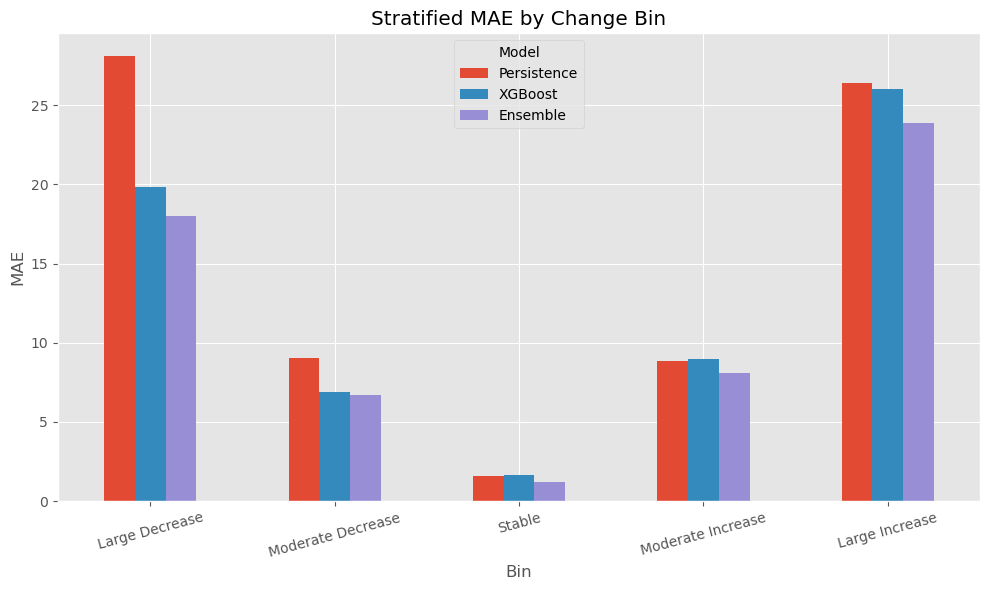

In [64]:
import pandas as pd
import matplotlib.pyplot as plt

# Sample data
data = {
    'Bin': ['Large Decrease', 'Moderate Decrease', 'Stable', 'Moderate Increase', 'Large Increase'],
    'Persistence': [28.14, 9.01, 1.56, 8.82, 26.41],
    'XGBoost': [19.81, 6.88, 1.65, 8.99, 26.05],
    'Ensemble': [18.00, 6.70, 1.20, 8.10, 23.90],  # hypothetical
}
df = pd.DataFrame(data)

df.set_index('Bin').plot(kind='bar', figsize=(10, 6))
plt.ylabel('MAE')
plt.title('Stratified MAE by Change Bin')
plt.xticks(rotation=15)
plt.legend(title='Model')
plt.tight_layout()
plt.show()


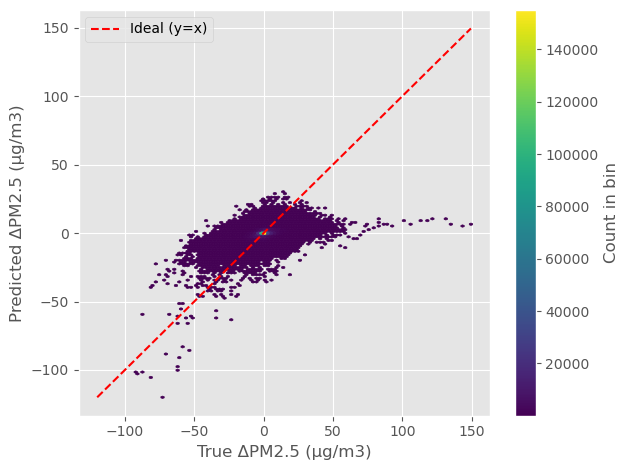

In [13]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')  # Try 'ggplot' as an alternative

# Assume df has columns delta_pm25_true, delta_pm25_pred
x = y_test
y = y_preds

hb = plt.hexbin(
    x, y,
    gridsize=(100),        # increase/decrease to control resolution (e.g. 50, 100, 200)
    cmap="viridis",      # any colormap you like
    mincnt=1             # only draw bins that have at least 1 point
)
plt.colorbar(hb, label="Count in bin")
# plot y=x reference line
mn = min(x.min(), y.min())
mx = max(x.max(), y.max())
plt.plot([mn, mx], [mn, mx], "r--", label="Ideal (y=x)")

plt.xlabel("True ΔPM2.5 (μg/m3)")
plt.ylabel("Predicted ΔPM2.5 (μg/m3)")
plt.legend()
plt.tight_layout()
plt.show()


Selected location for plotting: (22, 30)


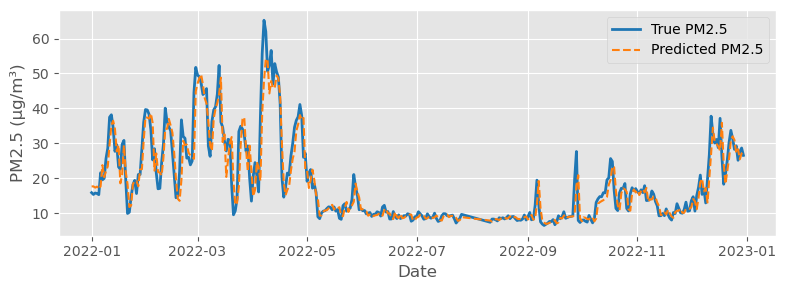

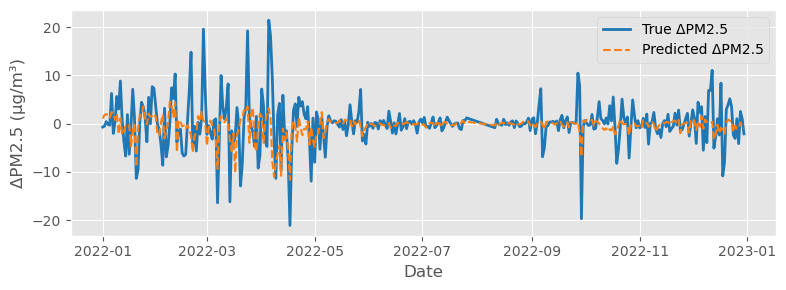

In [41]:
np.random.seed(900)
locs = test_df["i"].unique()
chosen_i = np.random.choice(locs)
chosen_j = np.random.choice(locs)
chosen_loc = (chosen_i, chosen_j)
print(f"Selected location for plotting: {chosen_loc}")

# ─── 4. Filter the DataFrame for that location & sort by date ────────────────
df_loc = test_df.query(f'i == {chosen_i} and j == {chosen_j}').sort_values("time")

y_test = df_loc['delta_pm25_t+1']

pm25_test = df_loc['pm25_t'] + y_test

y_preds = model.predict(df_loc.drop(['time', 'i', 'j', 'delta_pm25_t+1'], axis=1))

pm25_preds = df_loc['pm25_t'] + y_preds

# ─── 5. Plot true vs. predicted time series for that one cell ────────────────
plt.figure(figsize=(8, 3))
plt.plot(
    df_loc["time"],
    pm25_test,
    label="True PM2.5",
    linestyle="-",
    linewidth=2,
    color='tab:blue'
)
plt.plot(
    df_loc["time"],
    pm25_preds,
    label="Predicted PM2.5",
    linestyle="--",
    color='tab:orange'
)
plt.xlabel("Date")
plt.ylabel("PM2.5 (µg/m³)")
# plt.title(f"PM2.5 Time Series at Location = {chosen_loc}")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 3))
plt.plot(
    df_loc["time"],
    y_test,
    label="True ΔPM2.5",
    linestyle="-",
    linewidth=2,
    color='tab:blue'
)
plt.plot(
    df_loc["time"],
    y_preds,
    label="Predicted ΔPM2.5",
    linestyle="--",
    color='tab:orange'
)
plt.xlabel("Date")
plt.ylabel("ΔPM2.5 (µg/m³)")
# plt.title(f"ΔPM2.5 Time Series at Location = {chosen_loc}")
plt.legend()
plt.tight_layout()
plt.show()

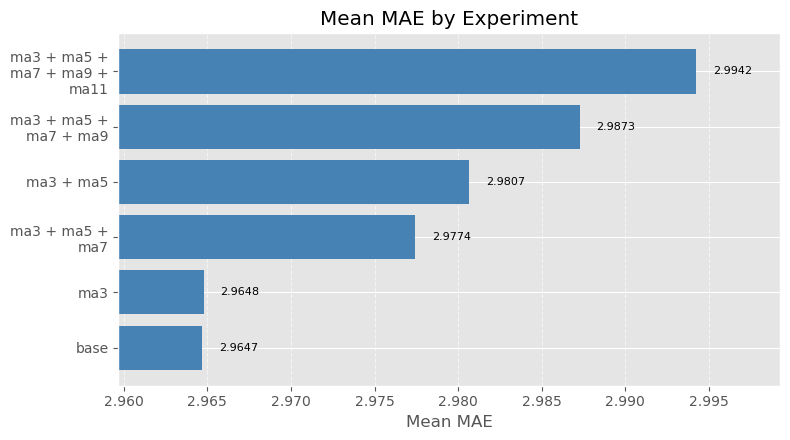

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Data with line breaks in long experiment names
experiment_results = [
    {"experiment": "base", "mean_mae": 2.964671},
    {"experiment": "ma3", "mean_mae": 2.964785},
    {"experiment": "ma3 + ma5", "mean_mae": 2.980672},
    {"experiment": "ma3 + ma5 +\nma7", "mean_mae": 2.977423},
    {"experiment": "ma3 + ma5 +\nma7 + ma9", "mean_mae": 2.987277},
    {"experiment": "ma3 + ma5 +\nma7 + ma9 +\nma11", "mean_mae": 2.994249},
]


df = pd.DataFrame(experiment_results).sort_values("mean_mae")

# Plot
plt.figure(figsize=(8, 4.5))
bars = plt.barh(df["experiment"], df["mean_mae"], color="steelblue")

# Annotate bars
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.001, bar.get_y() + bar.get_height() / 2,
             f"{width:.4f}", va="center", fontsize=8)

# Zoom in on x-axis
min_mae = df["mean_mae"].min()
max_mae = df["mean_mae"].max()
margin = 0.005
plt.xlim(min_mae - margin, max_mae + margin)

# Labels and layout
plt.xlabel("Mean MAE")
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

